In [5]:
# ─── 셀 0: protobuf 설치 ─────────────────────────────────────
%pip install protobuf


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizerFast, BertConfig, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


/home/kong/miniconda3/envs/urlbert-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR = "/home/kong/urlbert/url_bert/urlbert2"
CHECKPOINT_PATH = f"{BASE_DIR}/finetune/phishing/checkpoints/modelx_URLBERT_80.pth"
TEST_CSV = f"{BASE_DIR}/dataset/urlbert_input_test.csv"

In [3]:
df = pd.read_csv(TEST_CSV)
texts = df["text"].tolist()
# benign→0, malicious→1 매핑
labels = df["label"].map({"benign": 0, "malicious": 1}).tolist()

In [4]:
from collections import OrderedDict
import torch
from transformers import BertConfig, BertForSequenceClassification
from pytorch_pretrained_bert import BertTokenizer
# 1) 토크나이저 & 모델 초기화
tokenizer = BertTokenizer(f"{BASE_DIR}/bert_tokenizer/vocab.txt")

config = BertConfig.from_pretrained(f"{BASE_DIR}/bert_config", num_labels=2,
    vocab_size=5000)
model = BertForSequenceClassification(config)

# 2) 체크포인트 로드 & 키 교정
orig_state = torch.load(CHECKPOINT_PATH, map_location="cpu")
fixed_state = OrderedDict()
for k, v in orig_state.items():
    # 'bert.bert.' → 'bert.', 혹은 'module.' 제거 등
    new_k = k
    if new_k.startswith("bert.bert."):
        new_k = new_k.replace("bert.bert.", "bert.")
    # 만약 DataParallel 때문에 'module.' 접두사가 있다면
    if new_k.startswith("module."):
        new_k = new_k.replace("module.", "")
    fixed_state[new_k] = v

# 3) strict=False 로 로드해서 누락된 키/예상치 못한 키만 확인
missing, unexpected = model.load_state_dict(fixed_state, strict=False)
print("Missing keys   :", missing)
print("Unexpected keys:", unexpected)

# 4) 모델 GPU로 보내기 & 평가 모드
model.to(DEVICE)
model.eval()


/tmp/ipykernel_2060323/1629330464.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  orig_state = torch.load(CHECKPOINT_PATH, map_location="cpu")


Missing keys   : ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
Unexpected keys: []


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [5]:
# 1) 인코딩
enc = tokenizer.batch_encode_plus(
    texts,
    max_length=200,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=True,
)

# 2) Tensor로 변환
input_ids      = torch.tensor(enc['input_ids']).to(DEVICE)       # shape: [B, 512]
attention_mask = torch.tensor(enc['attention_mask']).to(DEVICE)  # shape: [B, 512]

# 3) 패딩(0) 위치만 1로 하는 token_type_ids 생성
token_type_ids = (input_ids == 0).long()  # 이제 tensor 연산이므로 .long() 호출 가능

# 4) DataLoader 구성
labels_tensor = torch.tensor(labels).to(DEVICE)
dataset = TensorDataset(input_ids, attention_mask, token_type_ids, labels_tensor)
loader  = DataLoader(dataset, batch_size=32)




AttributeError: 'BertTokenizer' object has no attribute 'batch_encode_plus'

In [6]:
preds, trues = [], []
with torch.no_grad():
    for input_ids, attention_mask, token_type_ids, label in loader:
        input_ids      = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        token_type_ids = token_type_ids.to(DEVICE)

        # token_type_ids 인자를 추가합니다
        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        ).logits

        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(batch_preds)
        trues.extend(label.cpu().numpy())

accuracy  = accuracy_score(trues, preds)
precision = precision_score(trues, preds)
recall    = recall_score(trues, preds)
f1        = f1_score(trues, preds)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


Accuracy : 0.0197
Precision: 0.0234
Recall   : 0.0236
F1 Score : 0.0235


In [7]:
missing, unexpected = model.load_state_dict(fixed_state, strict=False)
print("Missing keys   :", missing)
print("Unexpected keys:", unexpected)


Missing keys   : ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
Unexpected keys: []


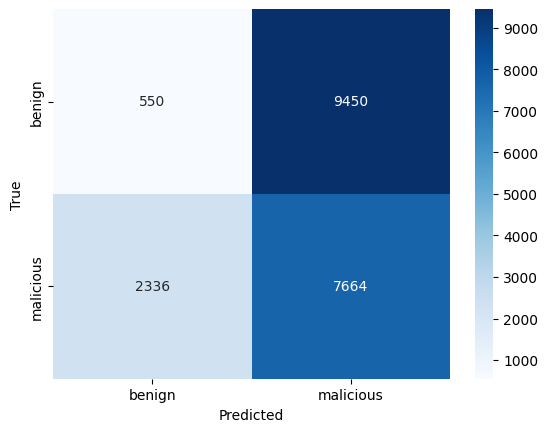

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(trues, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["benign","malicious"],
            yticklabels=["benign","malicious"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
